In [9]:
# all imports

import pyarrow.csv as pv
import pyarrow.parquet as pq
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import matplotlib.dates as mdates

In [10]:
# preprocessing function (polars)

csv_file = "2022_place_canvas_history.csv"
parquet_file = "2022pyarrow.parquet"

DATESTRING_FORMAT = "%Y-%m-%d %H:%M:%S"
BLOCK_SIZE = 100_000_000

read_options = pv.ReadOptions(block_size=BLOCK_SIZE)
csv_reader = pv.open_csv(csv_file, read_options=read_options)

parquet_writer = None

try:
    for record_batch in csv_reader:
        print(f"Processing batch with {record_batch.num_rows} rows...")

        df = pl.from_arrow(record_batch)

        # convert timstamp to datetime object
        df = df.with_columns(
            pl.col("timestamp")
            .str.replace(r" UTC$", "")  
            .str.strptime(
                pl.Datetime, 
                format="%Y-%m-%d %H:%M:%S%.f",
                strict=False
            )
            .alias("timestamp")
        )

        # split coordinate into cols 'x', 'y' 
        df = (
            df.filter(
                pl.col("coordinate").str.count_matches(",") == 1
            )
            .with_columns(
                pl.col("coordinate")
                .str.split_exact(",", 1)
                .struct.field("field_0")
                .cast(pl.Int64)
                .alias("x"),
                pl.col("coordinate")
                .str.split_exact(",", 1)
                .struct.field("field_1")
                .cast(pl.Int64)
                .alias("y"),
            )
            .drop("coordinate")
            )

        # map user_id to ints to save memory
        df = df.with_columns(
            pl.col('user_id')
            .cast(pl.Categorical)  # convert to categorical (assigns unique codes)
            .to_physical()         # get int rep
            .alias('user_id_int')
        )
        df = df.drop("user_id") # can drop user_id now

        table = df.to_arrow()

        if parquet_writer is None:
            parquet_writer = pq.ParquetWriter(
                parquet_file, 
                schema=table.schema, 
                compression="zstd"
            )
        parquet_writer.write_table(table)

finally:
    if parquet_writer:
        parquet_writer.close()

print(f"Successfully converted {csv_file} to {parquet_file}")

In [11]:
parquet_file = pq.ParquetFile("2022pyarrow.parquet")

row_count = parquet_file.metadata.num_rows
columns = parquet_file.schema.names

print(f"Number of rows: {row_count}")
print(f"Columns: {columns}")
# and parquet is 1.45 GB

Number of rows: 160353085
Columns: ['timestamp', 'pixel_color', 'x', 'y', 'user_id_int']


In [12]:
# can retrieve original user_id with: 

# df.with_columns(
#     pl.col('user_id_int')
#     .reverse()
#     .alias('user_id')
# )

# What are the top 3 most painted pixels?

In [13]:
parquet_file = "2022pyarrow.parquet"

lf = pl.scan_parquet(parquet_file)  # LazyFrame (efficient for big data)
lf.collect().head()

timestamp,pixel_color,x,y,user_id_int
datetime[μs],str,i64,i64,u32
2022-04-04 00:53:51.577,"""#00CCC0""",826,1048,0
2022-04-04 00:53:53.758,"""#94B3FF""",583,1031,1
2022-04-04 00:53:54.685,"""#6A5CFF""",1873,558,2
2022-04-04 00:54:57.541,"""#009EAA""",1627,255,3
2022-04-04 00:55:16.307,"""#94B3FF""",49,1478,4


In [14]:
top3_paint_counts = (
    lf.group_by(['x', 'y'])
    .agg(pl.len().alias('count')) # count occurances
    .sort('count', descending=True) # sort by count
    .limit(3) # top 3 pixels
)

top3_paint_counts.collect()

x,y,count
i64,i64,u32
0,0,98807
359,564,69198
349,564,55230


The top 3 painted pixels are at locations
1. (0, 0) painted 98807 times
2. (359, 564) painted 69198 times
3. (349, 564) painted 55230 times 

"The 2022 edition started with the same size and colors as 2017, but the canvas was later expanded to four million (2000 x 2000) pixel squares, and the palette gradually gained sixteen more colors for a total of 32."

- (0, 0) is located at the upper left corner of the canvas
- x move to right
- y move down

# Simple EDA: Why were the 3 most painted pixels hit so often?

## 1. Visualize positioning of pixels?
- distribution of count of painted pixels (entire count?)
- maybe visualization of concentration of how often pixels painted on entire canvas?
- were pixels near the top painted pixels, also hit pretty often?

In [15]:
paint_counts = (
    lf.group_by(['x', 'y'])
    .agg(pl.len().alias('count')) # count occurances
    .sort('count', descending=True) # sort by count
)

paint_counts.collect().head(10)

x,y,count
i64,i64,u32
0,0,98807
359,564,69198
349,564,55230
859,766,52261
860,766,51485
104,768,38086
105,768,34082
1999,1999,31437
1999,0,30882


^^ see some clustering in pairs

### Visualize with Heatmap

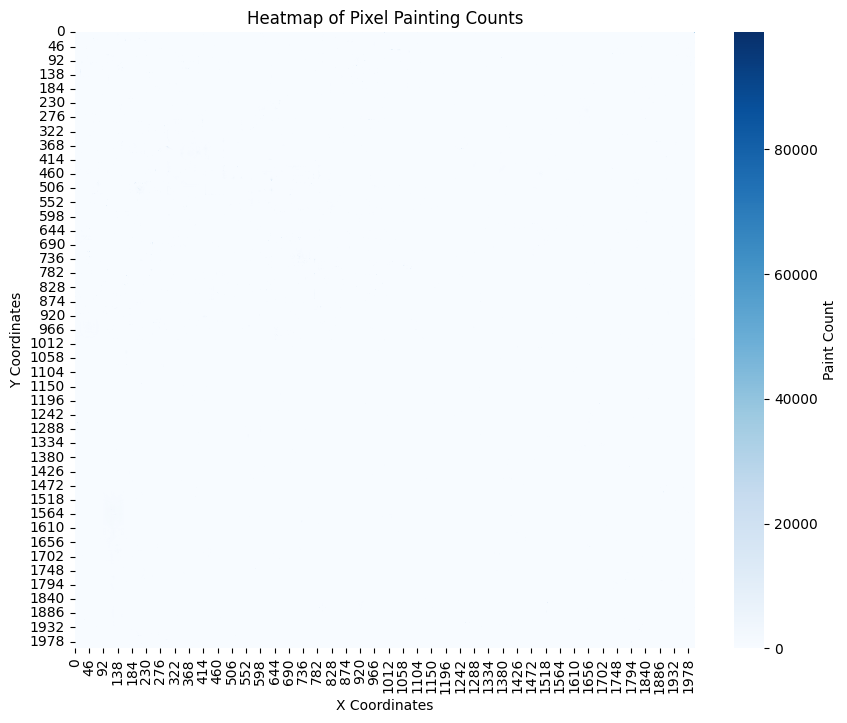

In [16]:
paint_counts_pd = paint_counts.collect().to_pandas() # need to convert to pandas to plot

heatmap_data = paint_counts_pd.pivot(index='y', columns='x', values='count').fillna(0) # define heatmap, pivot for grid-like structure

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='Blues', annot=False, fmt='g', cbar_kws={'label': 'Paint Count'})
plt.title('Heatmap of Pixel Painting Counts')
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.show()

Try by zooming in -> split into 4 sections (top left, bottom left, top right, bottom right) with smaller range of pixel counts

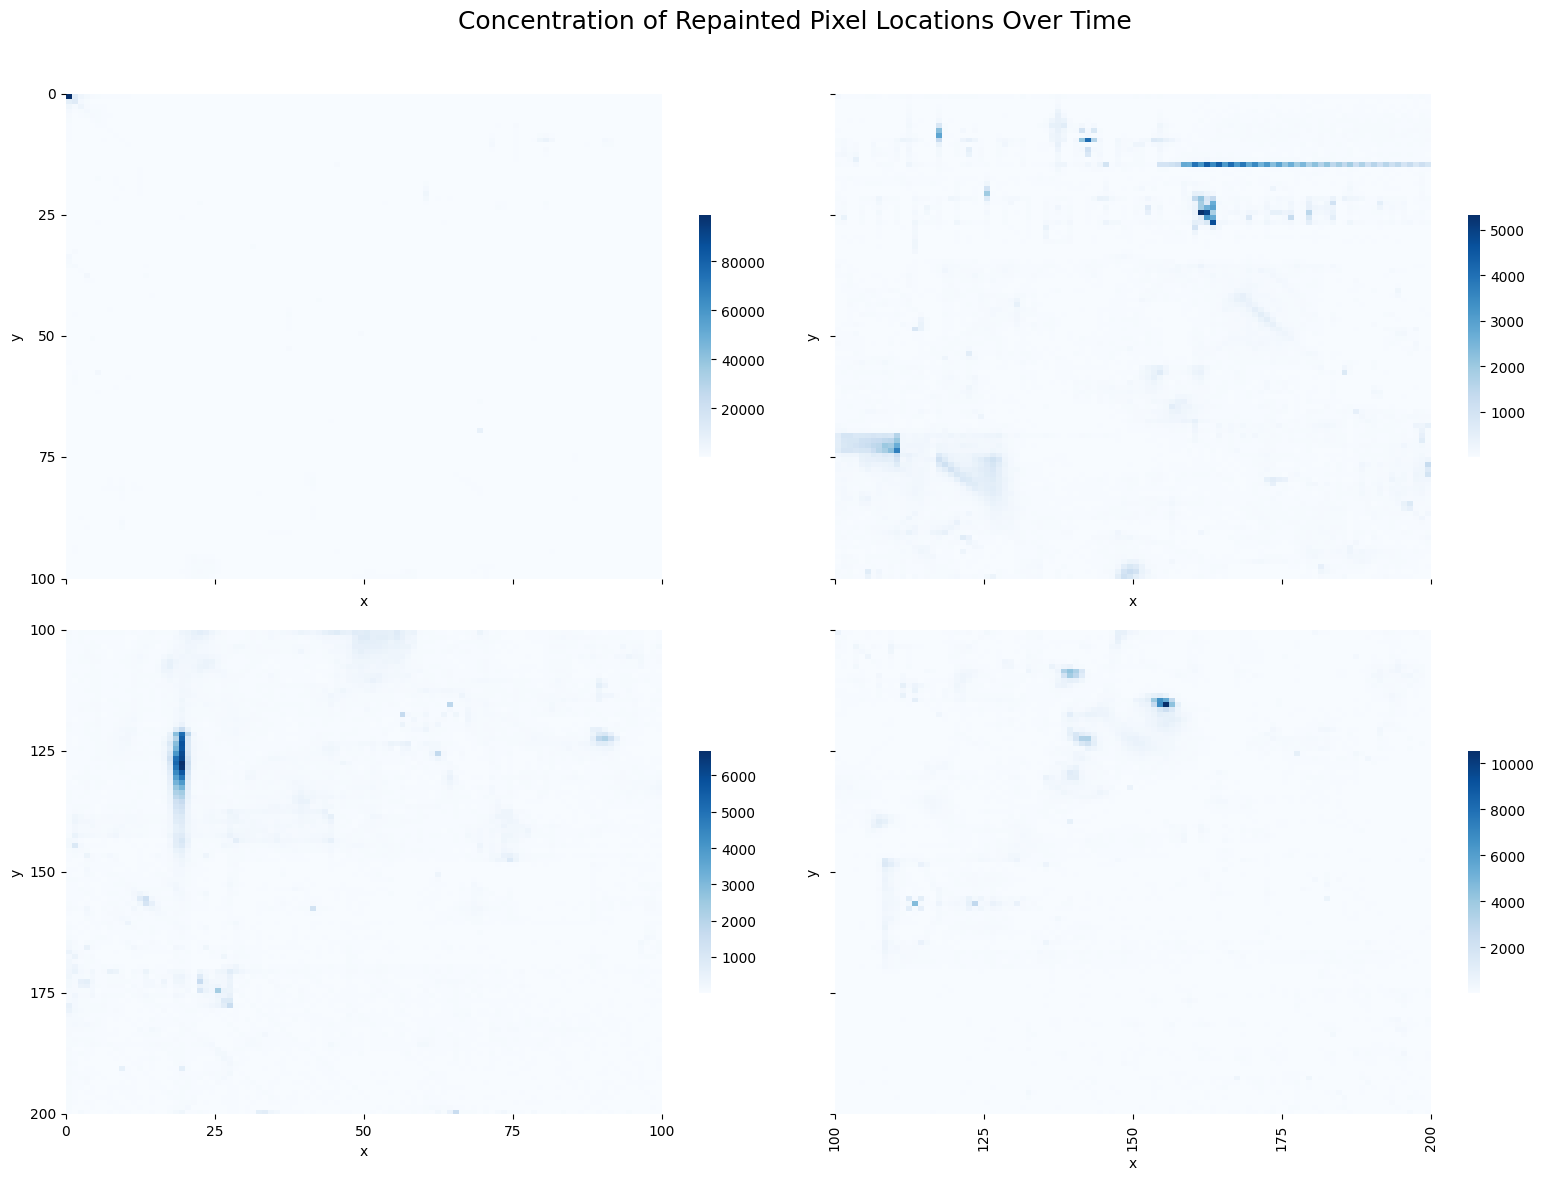

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

sections = [
    (0, 100, 0, 100, "Top-left Section"),
    (0, 100, 100, 200, "Top-right Section"),
    (100, 200, 0, 100, "Bottom-left Section"),
    (100, 200, 100, 200, "Bottom-right Section")
]

for ax, (y_start, y_end, x_start, x_end, title) in zip(axs.flat, sections):
    sns.heatmap(heatmap_data.iloc[y_start:y_end, x_start:x_end], 
                cmap='Blues', annot=False, fmt='g', ax=ax, 
                cbar_kws={"shrink": 0.5})  # adjust color bar size
    
    # ax.set_title(title)

    # set ticks from 0 to 100 by 25
    ax.set_xticks(np.arange(0, 101, 25))  # x-axis ticks every 25
    ax.set_xticklabels(np.arange(x_start, x_end + 1, 25))  # adjust to actual coordinates
    
    ax.set_yticks(np.arange(0, 101, 25))  # y-axis ticks every 25
    ax.set_yticklabels(np.arange(y_start, y_end + 1, 25))  # adjust to actual coordinates

# remove redundant ticks
for ax in axs[0, :]:  # remove x-axis ticks for top row
    ax.set_xticklabels([])
for ax in axs[:, 1]:  # remove y-axis ticks for right col
    ax.set_yticklabels([])

# Add overall title
fig.suptitle("Concentration of Repainted Pixel Locations Over Time", fontsize=18)

plt.tight_layout(rect=[0, 0, 1, 0.96]) # adjust to fit title
plt.show()


## 2. Look at colors
- what different colors were painted on the top 3 pixels?
    - how many colors for each pixel?
    - top colors for each pixel?
- what are top colors for entire dataset?

In [18]:
top3_colors_df = (
    lf.filter(
        ((pl.col('x') == 0) & (pl.col('y') == 0)) |  # (x=0, y=0)
        ((pl.col('x') == 359) & (pl.col('y') == 564)) |  # (x=359, y=564)
        ((pl.col('x') == 349) & (pl.col('y') == 564))  # (x=349, y=564)
    ) 
    .group_by(['x', 'y', 'pixel_color'])  # group by (x, y, pixel_color)
    .agg(pl.len().alias('color_count'))  # count occurrences of each color for each (x, y)
    .sort(['x', 'y', 'color_count'], descending=[False, False, True])  # sort by x, y and color count
    .group_by(['x', 'y'])  # group by (x, y) to aggregate top 3 colors for each pixel
    .agg(
        pl.col('pixel_color').head(3).alias('top_3_colors'),  # Get top 3 colors
        pl.col('color_count').head(3).alias('top_3_counts')  # Get top 3 color counts
    )
)

top3_colors_df.collect()  # Collect the results


x,y,top_3_colors,top_3_counts
i64,i64,list[str],list[u32]
349,564,"[""#000000"", ""#51E9F4"", ""#FF4500""]","[27804, 19404, 2120]"
0,0,"[""#FFFFFF"", ""#000000"", ""#FF4500""]","[59282, 8715, 4209]"
359,564,"[""#000000"", ""#51E9F4"", ""#FF4500""]","[34726, 26940, 1656]"


In [19]:
# top 3 colors for entire data?

top_colors_3 = (
    lf.group_by('pixel_color')  # Group by pixel_color
    .agg(pl.len().alias('color_count'))  # Count occurrences of each color
    .sort('color_count', descending=True)  # Sort by color_count in descending order
    .head(3)
)

top_colors_3.collect()

pixel_color,color_count
str,u32
"""#000000""",33707367
"""#FFFFFF""",32251013
"""#FF4500""",14411389


- white, black, orange/red are top 3 colors
- same as top pixels but light blue seems #7 most common

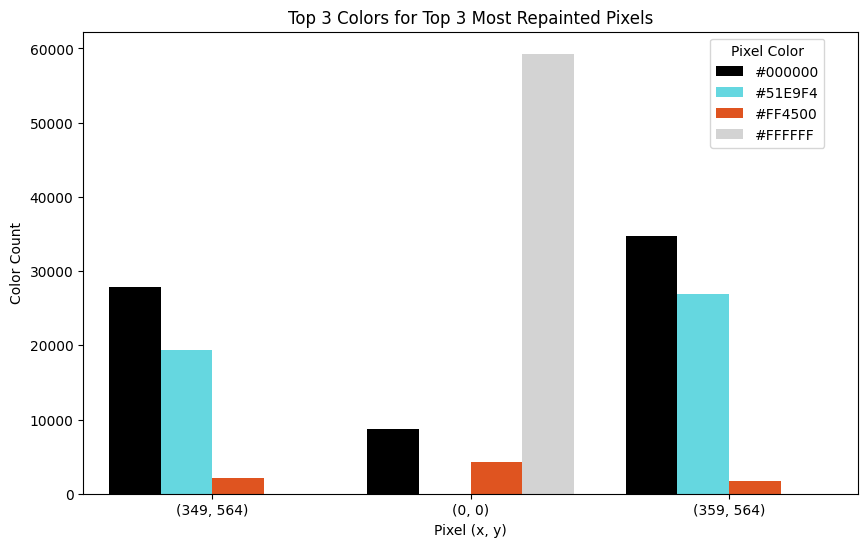

In [ ]:
top3_colors_long = top3_colors_df.explode(['top_3_colors', 'top_3_counts']) # long format, exploding lists into indiv rows

top3_colors_long_df = top3_colors_long.collect().to_pandas() # to pandas df

# coord to coord format
top3_colors_long_df['pixel_coordinates'] = '(' + top3_colors_long_df['x'].astype(str) + ', ' + top3_colors_long_df['y'].astype(str) + ')'

fig, ax = plt.subplots(figsize=(10, 6)) # plot
palette = {color: color for color in top3_colors_long_df['top_3_colors'].unique()} # same colors
sns.barplot(x='pixel_coordinates', y='top_3_counts', hue='top_3_colors', data=top3_colors_long_df, ax=ax, palette=palette)

for patch in ax.patches:
    if patch.get_facecolor() == (1.0, 1.0, 1.0, 1.0):  # check if white
        patch.set_facecolor('#D3D3D3')  # change white to light gray

ax.grid(False)
ax.legend(title='Pixel Color', loc='upper left', bbox_to_anchor=(0.8, 1))

ax.set_title('Top 3 Colors for Top 3 Most Repainted Pixels')
ax.set_xlabel('Pixel (x, y)')
ax.set_ylabel('Color Count')

plt.show()

# Look at 2022 final canvas and find corresponding pixels
- focus on meme culture, trends, etc.

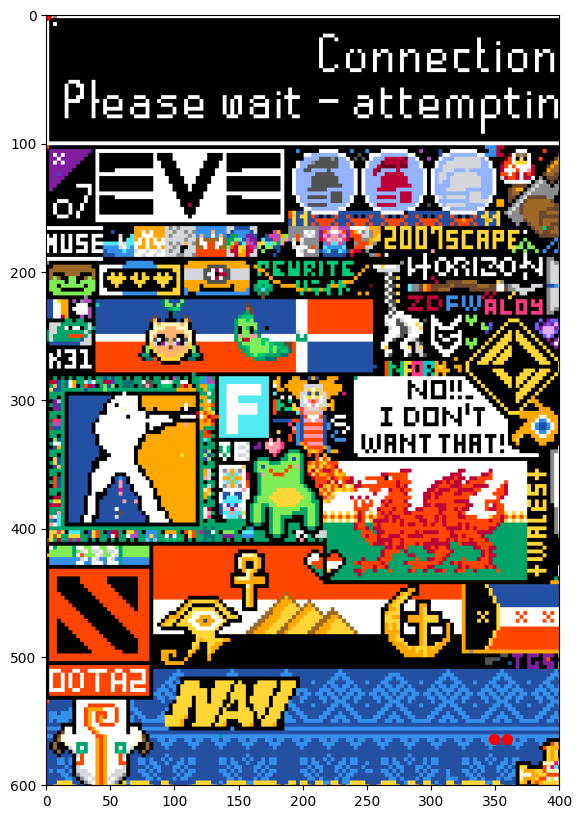

In [ ]:
canvas = Image.open("2022_canvas_final.png") # load in final r/place 2022 canva

top_pixels = [(0, 0), (359, 564), (349, 564)]  # def most painted pixels

width, height = 400, 600 # zoom into these dim

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(canvas)

for (x, y) in top_pixels: # mark top pixels
    ax.scatter(x, y, color='red', s=50)

ax.set_xlim(0, width)  
ax.set_ylim(height, 0)  # invert y-axis to align with image coordinates

plt.show()

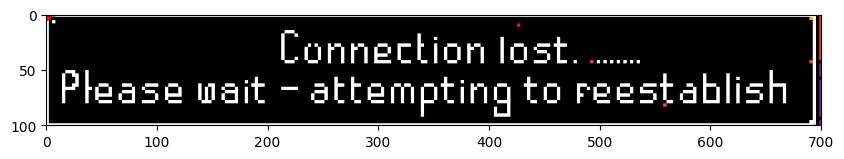

In [26]:
# create figure
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(canvas)

# mark top pixels
for (x, y) in top_pixels:
    ax.scatter(x, y, color='red', s=50)  # red dot at pixel location

ax.set_xlim(0, 700)  # adjust 
ax.set_ylim(100, 0)
plt.show()

# Look at (0, 0) -> Connection Lost banner

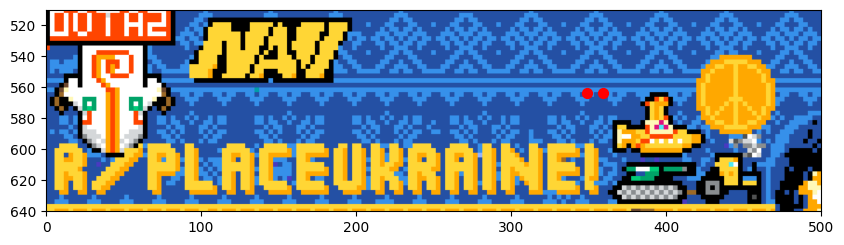

In [27]:
# create figure
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(canvas)

# mark top pixels
for (x, y) in top_pixels:
    ax.scatter(x, y, color='red', s=50)  # red dot at pixel location

ax.set_xlim(0, 500)  # adjust 
ax.set_ylim(640, 510)
plt.show()

# Look at (359, 564) and (349, 564) -> R/PLACEUKRAINE banner

^^ do some online research on
- Connection Lost banner
    - reference to RuneScape 
    - were pixels on this banner painted on a lot?

- R/PLACEUKRAINE banner
    - most likely due to support for Ukraine after Russia-Ukraine war in 2022
    - were pixels on this banner painted on a lot? (just the background, blue part)

- try users for each pixel across time

In [28]:
useractivitytime = (
    lf.with_columns([
        pl.col("timestamp").dt.truncate("1h").alias("hour")  # truncate timestamp to the hour
    ])
    .filter(
        ((pl.col('x') == 0) & (pl.col('y') == 0)) |  # (x=0, y=0)
        ((pl.col('x') == 359) & (pl.col('y') == 564)) |  # (x=359, y=564)
        ((pl.col('x') == 349) & (pl.col('y') == 564))  # (x=349, y=564)
    )
    .group_by(['hour', 'x', 'y'])  # group by the hour
    .agg(pl.len().alias('count'))
)

useractivitytime.collect()

hour,x,y,count
datetime[μs],i64,i64,u32
2022-04-01 16:00:00,359,564,573
2022-04-03 13:00:00,359,564,1038
2022-04-04 14:00:00,0,0,1311
2022-04-03 07:00:00,349,564,774
2022-04-04 16:00:00,0,0,1355
…,…,…,…
2022-04-03 07:00:00,0,0,574
2022-04-02 13:00:00,0,0,741
2022-04-01 22:00:00,359,564,950


In [29]:
useractivitytime_df = useractivitytime.collect().to_pandas()

pixel_counts_pivot = useractivitytime_df.pivot_table(
    index='hour',  
    columns=['x', 'y'], 
    values='count', 
    aggfunc='sum', 
    fill_value=0
)

print(pixel_counts_pivot.index[:10])  # check


DatetimeIndex(['2022-04-01 12:00:00', '2022-04-01 13:00:00',
               '2022-04-01 14:00:00', '2022-04-01 15:00:00',
               '2022-04-01 16:00:00', '2022-04-01 17:00:00',
               '2022-04-01 18:00:00', '2022-04-01 19:00:00',
               '2022-04-01 20:00:00', '2022-04-01 21:00:00'],
              dtype='datetime64[us]', name='hour', freq=None)


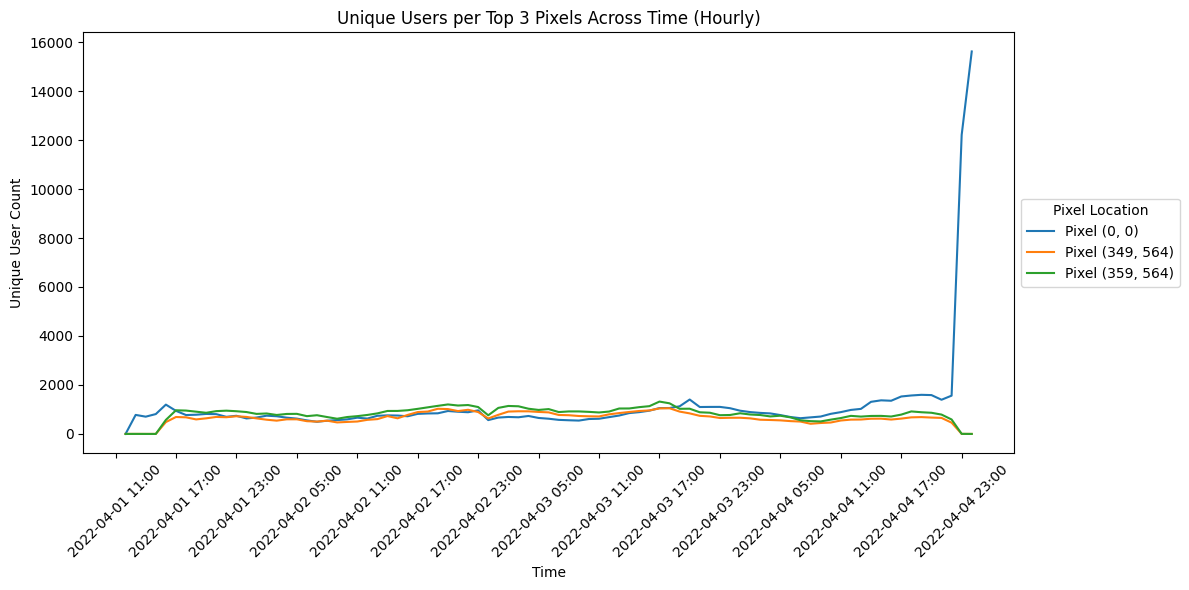

In [ ]:
plt.figure(figsize=(12, 6))

for column in pixel_counts_pivot.columns:
    plt.plot(
        pixel_counts_pivot.index, 
        pixel_counts_pivot[column], 
        label=f"Pixel {column}",
        linestyle='-', 
        markersize=6
    )

plt.title('Unique Users per Top 3 Pixels Across Time (Hourly)')
plt.xlabel('Time')
plt.ylabel('Unique User Count')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))  # show every 6 hours
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))  # show date and time in format

plt.xticks(rotation=45) # rotate
plt.legend(title='Pixel Location', loc='center left', bbox_to_anchor=(1, 0.5)) # move legend

plt.tight_layout()
plt.show()
